In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data preprocessing**

In [0]:
import pandas as pd
data=pd.read_csv('/content/drive/My Drive/train.csv')
data['image_id']+='.jpg'
data.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0


In [0]:
print('Distribution of classes:','\n',data['healthy'].value_counts())
print(data['multiple_diseases'].value_counts())
print(data['rust'].value_counts())
print(data['scab'].value_counts())
#we see that 'multiple_diseases' is outnumbered (28.3% 5% 34.1% 32.5%)

Distribution of classes: 
 0    1305
1     516
Name: healthy, dtype: int64
0    1730
1      91
Name: multiple_diseases, dtype: int64
0    1199
1     622
Name: rust, dtype: int64
0    1229
1     592
Name: scab, dtype: int64


In [0]:
data=data[1600:]
print('Distribution of classes:','\n',data['healthy'].value_counts())
print(data['multiple_diseases'].value_counts())
print(data['rust'].value_counts())
print(data['scab'].value_counts())

Distribution of classes: 
 0    154
1     67
Name: healthy, dtype: int64
0    210
1     11
Name: multiple_diseases, dtype: int64
0    146
1     75
Name: rust, dtype: int64
0    153
1     68
Name: scab, dtype: int64


In [0]:
import tensorflow as tf
import numpy as np
import keras

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator  

In [0]:
train_datagen=ImageDataGenerator( #transform train images with image augmentation
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)

In [0]:
train_generator=train_datagen.flow_from_dataframe( #1700 augmented train images 224x224x3
    dataframe=data[:1700],
    directory='/content/drive/My Drive/images',
    x_col="image_id",
    y_col=['healthy','multiple_diseases','rust','scab'],
    target_size=(224,224),
    batch_size=20,
    validate_filenames=True,
    class_mode='raw')

Found 1700 validated image filenames.


In [0]:
test_generator=train_datagen.flow_from_dataframe( #121 test images
    dataframe=data[1700:],
    directory='/content/drive/My Drive/images',
    x_col="image_id",
    y_col=['healthy','multiple_diseases','rust','scab'],
    target_size=(224,224),
    batch_size=1,
    validate_filenames=True,
    class_mode='raw')

Found 121 validated image filenames.


In [0]:
from keras import layers
from keras import models
from keras import optimizers

# **Without dropout**

In [0]:
network_1=models.Sequential()
network_1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
network_1.add(layers.Conv2D(64,(3,3), activation='relu'))
network_1.add(layers.MaxPooling2D((2,2)))
network_1.add(layers.Conv2D(64,(3,3), activation='relu'))
network_1.add(layers.MaxPooling2D((2,2)))
network_1.add(layers.Conv2D(128,(3,3), activation='relu'))
network_1.add(layers.MaxPooling2D((2,2)))
network_1.add(layers.Conv2D(128,(3,3), activation='relu'))
network_1.add(layers.MaxPooling2D((2,2)))
network_1.add(layers.Conv2D(256,(3,3), activation='relu'))
network_1.add(layers.MaxPooling2D((2,2)))
network_1.add(layers.Flatten())
network_1.add(layers.Dense(512,activation='relu'))
network_1.add(layers.Dense(4,activation='softmax'))

In [0]:
network_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 128)      

In [0]:
network_1.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=['acc'])

In [0]:
class_weight = {0: 1., #weights for imbalanced data
                1: 5.67,
                2: 0.83,
                3: 0.88}

In [0]:
history=network_1.fit_generator(
train_generator,
steps_per_epoch=85,
epochs=25,
validation_data=test_generator,
validation_steps=121,
class_weight=class_weight)

Epoch 1/25
85/85 [==============================] - 763s 9s/step - loss: 1.5878 - acc: 0.2665 - val_loss: 1.3454 - val_acc: 0.3058
Epoch 2/25
85/85 [==============================] - 75s 884ms/step - loss: 1.5590 - acc: 0.3812 - val_loss: 0.7684 - val_acc: 0.3636
Epoch 3/25
85/85 [==============================] - 80s 943ms/step - loss: 1.5342 - acc: 0.3606 - val_loss: 1.6901 - val_acc: 0.2149
Epoch 4/25
85/85 [==============================] - 81s 947ms/step - loss: 1.5297 - acc: 0.3706 - val_loss: 1.0052 - val_acc: 0.5289
Epoch 5/25
85/85 [==============================] - 81s 949ms/step - loss: 1.4716 - acc: 0.5100 - val_loss: 0.9279 - val_acc: 0.5702
Epoch 6/25
85/85 [==============================] - 81s 951ms/step - loss: 1.4157 - acc: 0.5294 - val_loss: 1.0286 - val_acc: 0.6364
Epoch 7/25
85/85 [==============================] - 81s 951ms/step - loss: 1.3663 - acc: 0.5912 - val_loss: 2.8073 - val_acc: 0.5868
Epoch 8/25
85/85 [==============================] - 81s 952ms/step - lo

In [0]:
network_1.save('25ep_-drop_+aug.h5')

In [0]:
import matplotlib.pyplot as plt #exponential smoothing
%matplotlib inline
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

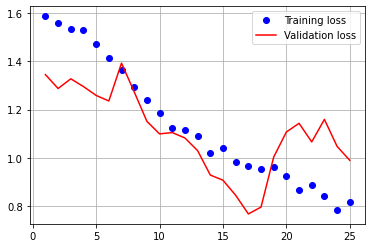

In [0]:
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'r',label='Validation loss')
plt.grid()
plt.legend()
plt.show()

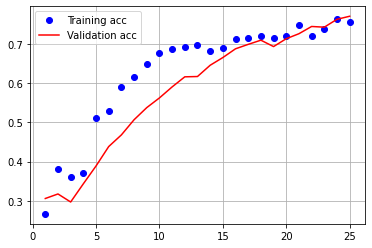

In [0]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc,factor=0.8),'r',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

In [0]:
#let`s add 10 epochs
history_1=network_1.fit_generator(
train_generator,
steps_per_epoch=85,
epochs=10,
validation_data=test_generator,
validation_steps=121,
class_weight=class_weight)

Epoch 1/10
85/85 [==============================] - 81s 959ms/step - loss: 0.7879 - acc: 0.7694 - val_loss: 0.8080 - val_acc: 0.7521
Epoch 2/10
85/85 [==============================] - 77s 909ms/step - loss: 0.7718 - acc: 0.7724 - val_loss: 1.3305 - val_acc: 0.6364
Epoch 3/10
85/85 [==============================] - 78s 913ms/step - loss: 0.7399 - acc: 0.7865 - val_loss: 0.1327 - val_acc: 0.7438
Epoch 4/10
85/85 [==============================] - 77s 911ms/step - loss: 0.7734 - acc: 0.7812 - val_loss: 0.0111 - val_acc: 0.8430
Epoch 5/10
85/85 [==============================] - 78s 912ms/step - loss: 0.7212 - acc: 0.7982 - val_loss: 0.4975 - val_acc: 0.7190
Epoch 6/10
85/85 [==============================] - 78s 914ms/step - loss: 0.7216 - acc: 0.7859 - val_loss: 0.0059 - val_acc: 0.8182
Epoch 7/10
85/85 [==============================] - 78s 920ms/step - loss: 0.7166 - acc: 0.8029 - val_loss: 0.0146 - val_acc: 0.8017
Epoch 8/10
85/85 [==============================] - 78s 916ms/step - 

In [0]:
acc=history_1.history['acc']
val_acc=history_1.history['val_acc']
loss=history_1.history['loss']
val_loss=history_1.history['val_loss']

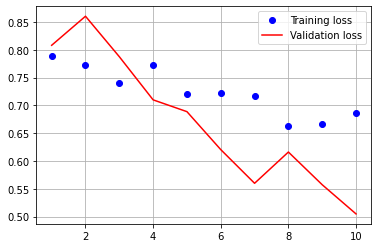

In [0]:
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'r',label='Validation loss')
plt.grid()
plt.legend()
plt.show()

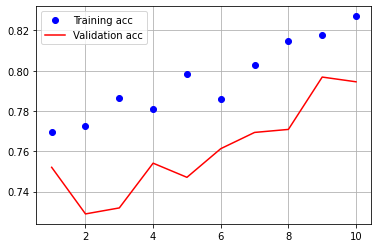

In [0]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc,factor=0.8),'r',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

In [0]:
network_1.save('35ep_-drop_+aug.h5')

In [0]:
#let`s add 20 epochs
history_1=network_1.fit_generator(
train_generator,
steps_per_epoch=85,
epochs=20,
validation_data=test_generator,
validation_steps=121,
class_weight=class_weight)

Epoch 1/20
85/85 [==============================] - 83s 978ms/step - loss: 0.6389 - acc: 0.8306 - val_loss: 1.3824 - val_acc: 0.7107
Epoch 2/20
85/85 [==============================] - 78s 912ms/step - loss: 0.6866 - acc: 0.8247 - val_loss: 1.4612 - val_acc: 0.6198
Epoch 3/20
85/85 [==============================] - 77s 909ms/step - loss: 0.6448 - acc: 0.8329 - val_loss: 1.0491 - val_acc: 0.7686
Epoch 4/20
85/85 [==============================] - 78s 914ms/step - loss: 0.6113 - acc: 0.8294 - val_loss: 0.1140 - val_acc: 0.7769
Epoch 5/20
85/85 [==============================] - 77s 910ms/step - loss: 0.6439 - acc: 0.8194 - val_loss: 1.0194 - val_acc: 0.7769
Epoch 6/20
85/85 [==============================] - 77s 906ms/step - loss: 0.6411 - acc: 0.8224 - val_loss: 0.0046 - val_acc: 0.8760
Epoch 7/20
85/85 [==============================] - 77s 902ms/step - loss: 0.6385 - acc: 0.8382 - val_loss: 0.0320 - val_acc: 0.7273
Epoch 8/20
85/85 [==============================] - 77s 909ms/step - 

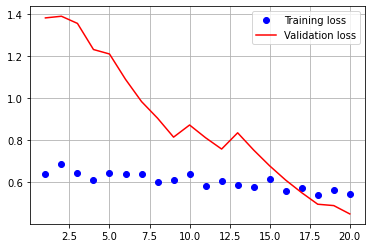

In [0]:
acc=history_1.history['acc']
val_acc=history_1.history['val_acc']
loss=history_1.history['loss']
val_loss=history_1.history['val_loss']

epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'r',label='Validation loss')
plt.grid()
plt.legend()
plt.show()

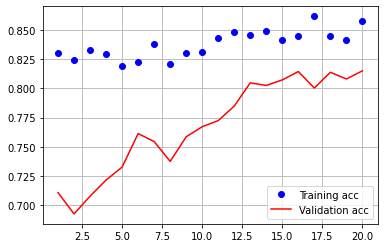

In [0]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc,factor=0.8),'r',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

In [0]:
network_1.save('55ep_-drop_224.h5')

In [0]:
test_loss, test_acc = network_1.evaluate_generator(test_generator, steps=121)
print('test acc:', test_acc)

test acc: 0.8347107172012329


In [0]:
from keras.models import load_model
network_1=load_model('/content/drive/My Drive/55ep_-drop_224.h5')

In [0]:
network_1.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=[tf.keras.metrics.Precision(class_id=0, name='Precision_0'),
                        tf.keras.metrics.Precision(class_id=1, name='Precision_1'),
                        tf.keras.metrics.Precision(class_id=2, name='Precision_2'),
                        tf.keras.metrics.Precision(class_id=3, name='Precision_3'),
                        
                        tf.keras.metrics.Recall(class_id=0, name='Recall_0'),
                        tf.keras.metrics.Recall(class_id=1, name='Recall_1'),
                        tf.keras.metrics.Recall(class_id=2, name='Recall_2'),
                        tf.keras.metrics.Recall(class_id=3, name='Recall_3'),
               ])

In [0]:
test_loss, precision_0, precision_1, precision_2, precision_3, recall_0, recall_1, recall_2, recall_3 = network_1.evaluate_generator(test_generator, steps=121)
mean_precision = (precision_0 + precision_1 + precision_2 + precision_3) /4
mean_recall = (recall_0 + recall_1 + recall_2 + recall_3) /4
print('Precision:', precision_0, precision_1, precision_2, precision_3)
print('Precision_mean:', mean_precision)
print('Recall:', recall_0, recall_1, recall_2, recall_3 )
print('Precision_mean:', mean_recall)

Precision: 0.8617739081382751 0.28023046255111694 0.93533855676651 0.9815400838851929
Precision_mean: 0.7647207528352737
Recall: 0.8236843943595886 0.5170800685882568 0.8765420913696289 0.8862596154212952
Precision_mean: 0.7758915424346924


# **Dropout = 0.5**

In [0]:
network_drop=models.Sequential()
network_drop.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
network_drop.add(layers.Conv2D(64,(3,3), activation='relu'))
network_drop.add(layers.MaxPooling2D((2,2)))
network_drop.add(layers.Conv2D(64,(3,3), activation='relu'))
network_drop.add(layers.MaxPooling2D((2,2)))
network_drop.add(layers.Conv2D(128,(3,3), activation='relu'))
network_drop.add(layers.MaxPooling2D((2,2)))
network_drop.add(layers.Conv2D(128,(3,3), activation='relu'))
network_drop.add(layers.MaxPooling2D((2,2)))
network_drop.add(layers.Conv2D(256,(3,3), activation='relu'))
network_drop.add(layers.MaxPooling2D((2,2)))
network_drop.add(layers.Flatten())
network_drop.add(layers.Dropout(0.5))
network_drop.add(layers.Dense(512,activation='relu'))
network_drop.add(layers.Dense(4,activation='softmax'))

In [0]:
class_weight = {0: 1.,
                1: 5.7,
                2: 0.83,
                3: 0.88}

In [0]:
network_drop.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=['acc'])

In [0]:
history_drop=network_drop.fit_generator(
train_generator,
steps_per_epoch=85,
epochs=65,
validation_data=test_generator,
validation_steps=121,
class_weight=class_weight)

Epoch 1/65
85/85 [==============================] - 681s 8s/step - loss: 1.5900 - acc: 0.3118 - val_loss: 1.3848 - val_acc: 0.3719
Epoch 2/65
85/85 [==============================] - 84s 992ms/step - loss: 1.5805 - acc: 0.3765 - val_loss: 1.3081 - val_acc: 0.3719
Epoch 3/65
85/85 [==============================] - 90s 1s/step - loss: 1.5580 - acc: 0.3976 - val_loss: 1.2061 - val_acc: 0.4050
Epoch 4/65
85/85 [==============================] - 89s 1s/step - loss: 1.5499 - acc: 0.4035 - val_loss: 1.0119 - val_acc: 0.4132
Epoch 5/65
85/85 [==============================] - 90s 1s/step - loss: 1.5355 - acc: 0.3759 - val_loss: 1.2128 - val_acc: 0.3058
Epoch 6/65
85/85 [==============================] - 90s 1s/step - loss: 1.5364 - acc: 0.3882 - val_loss: 1.7556 - val_acc: 0.4545
Epoch 7/65
85/85 [==============================] - 90s 1s/step - loss: 1.5378 - acc: 0.4065 - val_loss: 1.3342 - val_acc: 0.4050
Epoch 8/65
85/85 [==============================] - 90s 1s/step - loss: 1.5043 - acc: 

In [0]:
network_drop.save('65ep_d0.5_224.h5')

In [0]:
acc=history_drop.history['acc']
val_acc=history_drop.history['val_acc']
loss=history_drop.history['loss']
val_loss=history_drop.history['val_loss']

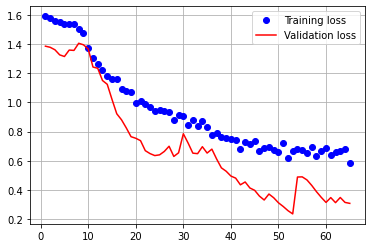

In [0]:
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss),'r',label='Validation loss')
plt.grid()
plt.legend()
plt.show()

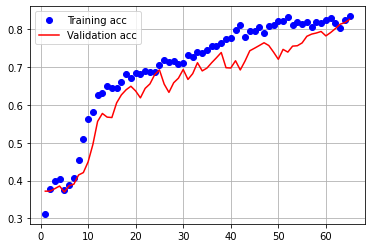

In [0]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc,factor=0.8),'r',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

In [0]:
test_generator.reset()
test_loss, test_acc = network_drop.evaluate_generator(test_generator, steps=121)
print('test acc:', test_acc)

test acc: 0.8677685856819153


In [0]:
network_drop.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=[tf.keras.metrics.Precision(class_id=0, name='Precision_0'),
                        tf.keras.metrics.Precision(class_id=1, name='Precision_1'),
                        tf.keras.metrics.Precision(class_id=2, name='Precision_2'),
                        tf.keras.metrics.Precision(class_id=3, name='Precision_3'),
                        
                        tf.keras.metrics.Recall(class_id=0, name='Recall_0'),
                        tf.keras.metrics.Recall(class_id=1, name='Recall_1'),
                        tf.keras.metrics.Recall(class_id=2, name='Recall_2'),
                        tf.keras.metrics.Recall(class_id=3, name='Recall_3'),
               ])

In [0]:
test_generator.reset()
test_loss_drop, precision_0_drop, precision_1_drop, precision_2_drop, precision_3_drop, recall_0_drop, recall_1_drop, recall_2_drop, recall_3_drop = network_drop.evaluate_generator(test_generator, steps=121)
mean_precision_drop = (precision_0_drop + precision_1_drop + precision_2_drop + precision_3_drop) /4
mean_recall_drop = (recall_0_drop + recall_1_drop + recall_2_drop + recall_3_drop) /4
print('Precision:', precision_0_drop, precision_1_drop, precision_2_drop, precision_3_drop)
print('Precision_mean:', mean_precision_drop)
print('Recall:', recall_0_drop, recall_1_drop, recall_2_drop, recall_3_drop )
print('Precision_mean:', mean_recall_drop)

Precision: 0.8725460171699524 0.31186890602111816 0.9151269197463989 0.9089617133140564
Precision_mean: 0.7521258890628815
Recall: 0.8103156685829163 0.3068554997444153 0.9046842455863953 0.8594678044319153
Precision_mean: 0.7203308045864105


# **Dropout=0.3**


In [0]:
network_03=models.Sequential()
network_03.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
network_03.add(layers.Conv2D(64,(3,3), activation='relu'))
network_03.add(layers.MaxPooling2D((2,2)))
network_03.add(layers.Conv2D(64,(3,3), activation='relu'))
network_03.add(layers.MaxPooling2D((2,2)))
network_03.add(layers.Conv2D(128,(3,3), activation='relu'))
network_03.add(layers.MaxPooling2D((2,2)))
network_03.add(layers.Conv2D(128,(3,3), activation='relu'))
network_03.add(layers.MaxPooling2D((2,2)))
network_03.add(layers.Conv2D(256,(3,3), activation='relu'))
network_03.add(layers.MaxPooling2D((2,2)))
network_03.add(layers.Flatten())
network_03.add(layers.Dropout(0.3))
network_03.add(layers.Dense(512,activation='relu'))
network_03.add(layers.Dense(4,activation='softmax'))

In [0]:
class_weight = {0: 1.,
                1: 5.67,
                2: 0.83,
                3: 0.88}

In [0]:
network_03.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=['acc'])

In [0]:
train_generator.reset()
test_generator.reset()

In [0]:
history_03=network_03.fit_generator(
train_generator,
steps_per_epoch=85,
epochs=70,
validation_data=test_generator,
validation_steps=121,
class_weight=class_weight)

Epoch 1/70
85/85 [==============================] - 94s 1s/step - loss: 1.5842 - acc: 0.2882 - val_loss: 1.3086 - val_acc: 0.3967
Epoch 2/70
85/85 [==============================] - 88s 1s/step - loss: 1.5613 - acc: 0.4053 - val_loss: 1.2122 - val_acc: 0.5207
Epoch 3/70
85/85 [==============================] - 88s 1s/step - loss: 1.5000 - acc: 0.5029 - val_loss: 1.0953 - val_acc: 0.5124
Epoch 4/70
85/85 [==============================] - 88s 1s/step - loss: 1.4030 - acc: 0.5535 - val_loss: 0.8410 - val_acc: 0.6281
Epoch 5/70
85/85 [==============================] - 88s 1s/step - loss: 1.3438 - acc: 0.5712 - val_loss: 1.2361 - val_acc: 0.6612
Epoch 6/70
85/85 [==============================] - 88s 1s/step - loss: 1.2726 - acc: 0.6382 - val_loss: 0.0696 - val_acc: 0.6364
Epoch 7/70
85/85 [==============================] - 88s 1s/step - loss: 1.2273 - acc: 0.6341 - val_loss: 0.1025 - val_acc: 0.6777
Epoch 8/70
85/85 [==============================] - 88s 1s/step - loss: 1.1748 - acc: 0.65

In [0]:
network_03.save('70ep_d0.3_224.h5')

In [0]:
acc=history_03.history['acc']
val_acc=history_03.history['val_acc']
loss=history_03.history['loss']
val_loss=history_03.history['val_loss']

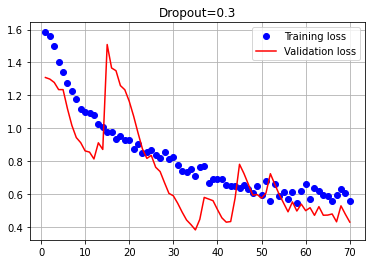

In [0]:
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,smooth_curve(val_loss, factor=0.9),'r',label='Validation loss')
plt.grid()
plt.title('Dropout=0.3')
plt.legend()
plt.show()

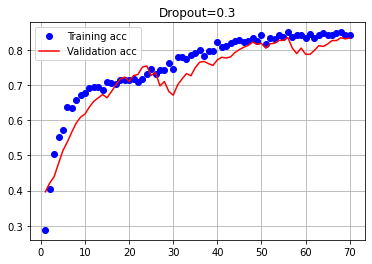

In [0]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,smooth_curve(val_acc,factor=0.8),'r',label='Validation acc')
plt.grid()
plt.legend()
plt.title('Dropout=0.3')
plt.show()

In [0]:
test_generator.reset()
test_loss, test_acc = network_03.evaluate_generator(test_generator, steps=121)
print('test acc:', test_acc)

test acc: 0.8677685856819153


In [0]:
network_03.compile(loss='categorical_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=[tf.keras.metrics.Precision(class_id=0, name='Precision_0'),
                        tf.keras.metrics.Precision(class_id=1, name='Precision_1'),
                        tf.keras.metrics.Precision(class_id=2, name='Precision_2'),
                        tf.keras.metrics.Precision(class_id=3, name='Precision_3'),
                        
                        tf.keras.metrics.Recall(class_id=0, name='Recall_0'),
                        tf.keras.metrics.Recall(class_id=1, name='Recall_1'),
                        tf.keras.metrics.Recall(class_id=2, name='Recall_2'),
                        tf.keras.metrics.Recall(class_id=3, name='Recall_3'),
               ])

In [0]:
test_generator.reset()
test_loss_drop, precision_0_drop, precision_1_drop, precision_2_drop, precision_3_drop, recall_0_drop, recall_1_drop, recall_2_drop, recall_3_drop = network_drop.evaluate_generator(test_generator, steps=121)
mean_precision_drop = (precision_0_drop + precision_1_drop + precision_2_drop + precision_3_drop) /4
mean_recall_drop = (recall_0_drop + recall_1_drop + recall_2_drop + recall_3_drop) /4
print('Precision:', precision_0_drop, precision_1_drop, precision_2_drop, precision_3_drop)
print('Precision_mean:', mean_precision_drop)
print('Recall:', recall_0_drop, recall_1_drop, recall_2_drop, recall_3_drop )
print('Precision_mean:', mean_recall_drop)

Precision: 0.9195013642311096 0.5588134527206421 0.9449580907821655 0.7858542203903198
Precision_mean: 0.8022817820310593
Recall: 0.7362736463546753 0.44998815655708313 0.942013144493103 0.9018502235412598
Precision_mean: 0.7575312927365303


# **Conclusion**



1.   With using **dropout** we can boost CNN **accuracy** (83,4% without **dropout** vs 86,7% with **dropout**), also with **dropout = 0.3** we can see increasing of **average recall, average precision** than without **dropout** (0.72, 0.75 vs 0.75, 0.80)  
2.   With **dropout = 0.3** i got 80% validation **accuracy** for 45 epochs, with  **dropout = 0.5** 80% i got only after 60 epochs, and **average recall, average precision** higher with 0.3. I think that **dropout = 0.3** better than 0.5


# **Feature maps**

In [0]:
from keras.preprocessing import image
import numpy as np
img=image.load_img('/content/drive/My Drive/images/Train_3.jpg',target_size=(224,224))
img_tensor=image.img_to_array(img)
img_tensor=np.expand_dims(img_tensor,axis=0)
img_tensor/=255.

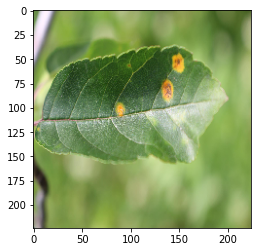

In [0]:
plt.imshow(img_tensor[0])

In [0]:
layer_outputs=[layer.output for layer in network_03.layers[:11]]
activation_model=models.Model(inputs=network_03.input,outputs=layer_outputs)

In [0]:
activations=activation_model.predict(img_tensor)
f=activations[0]

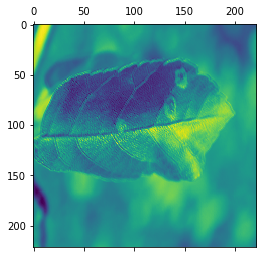

In [0]:
plt.matshow(f[0,:,:,5],cmap='viridis') # 5 channel in 1st conv layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


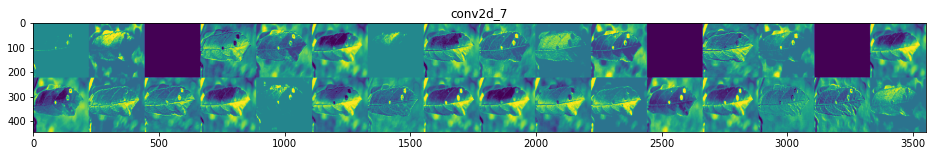

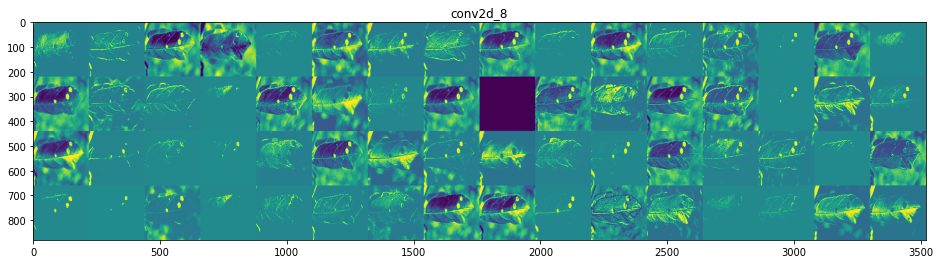

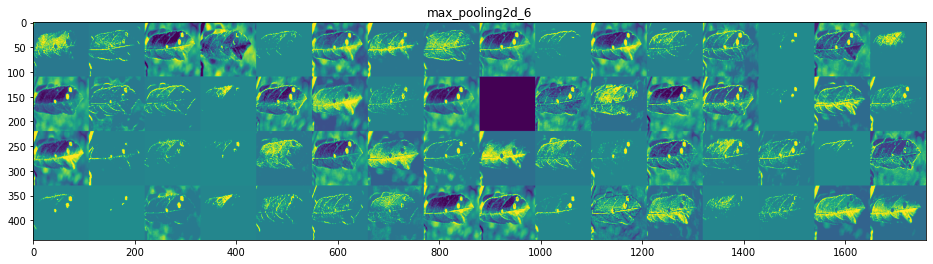

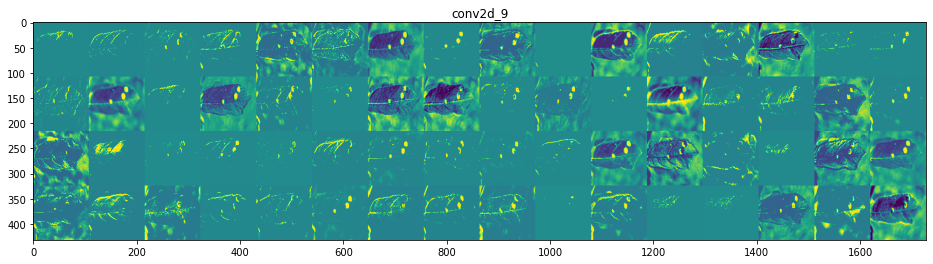

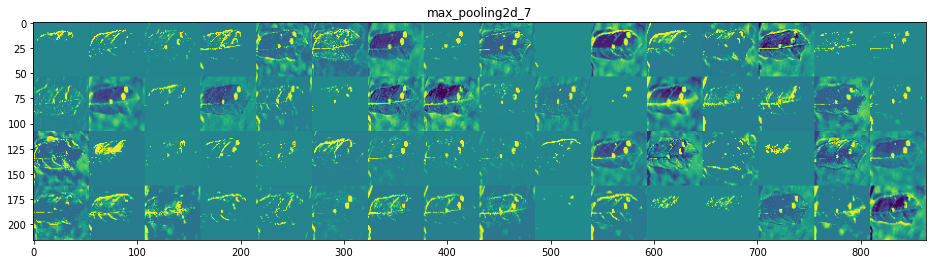

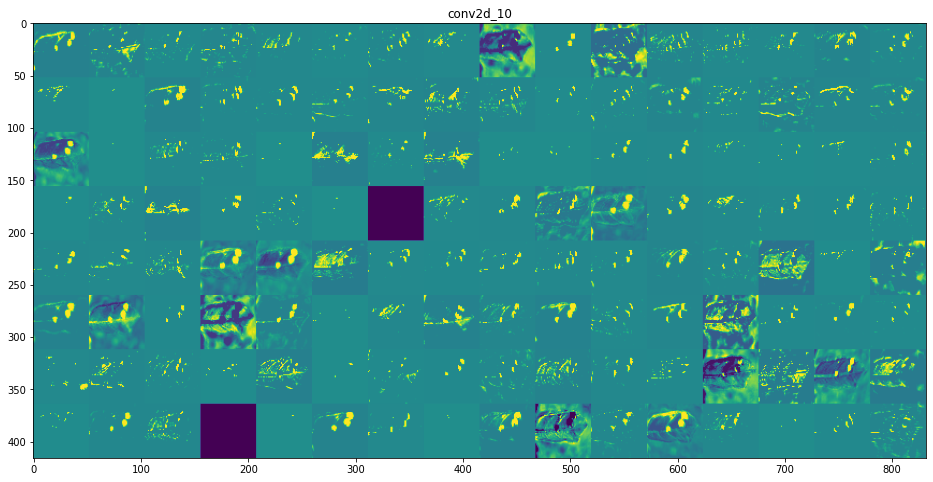

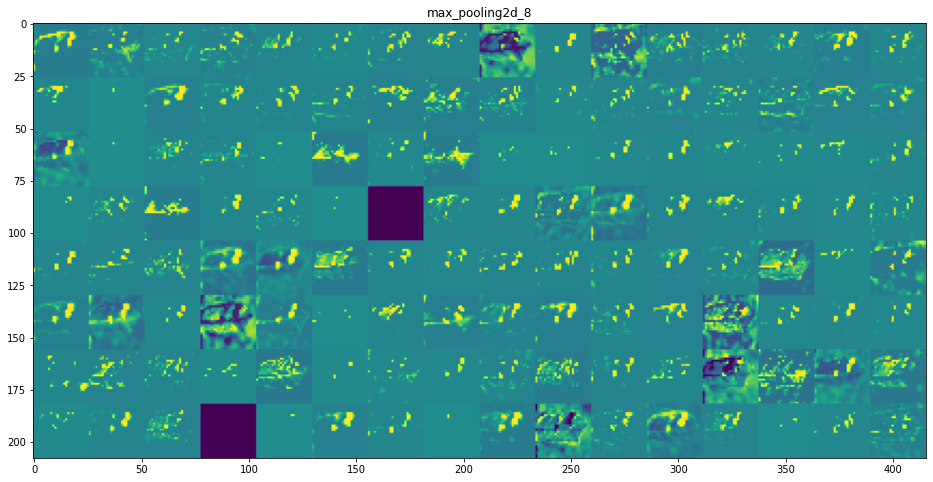

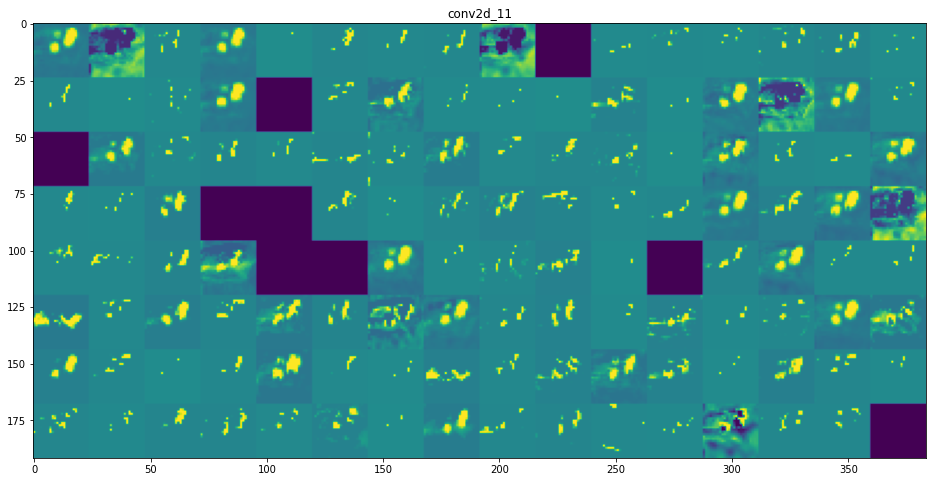

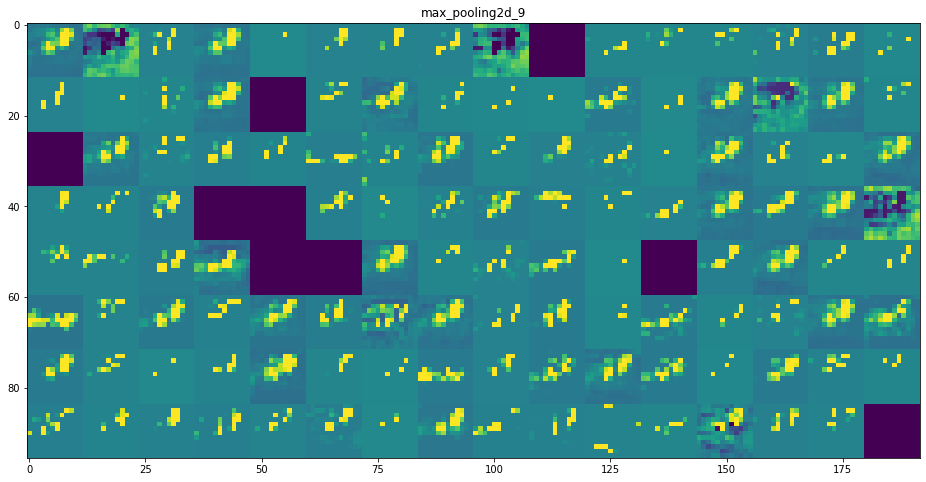

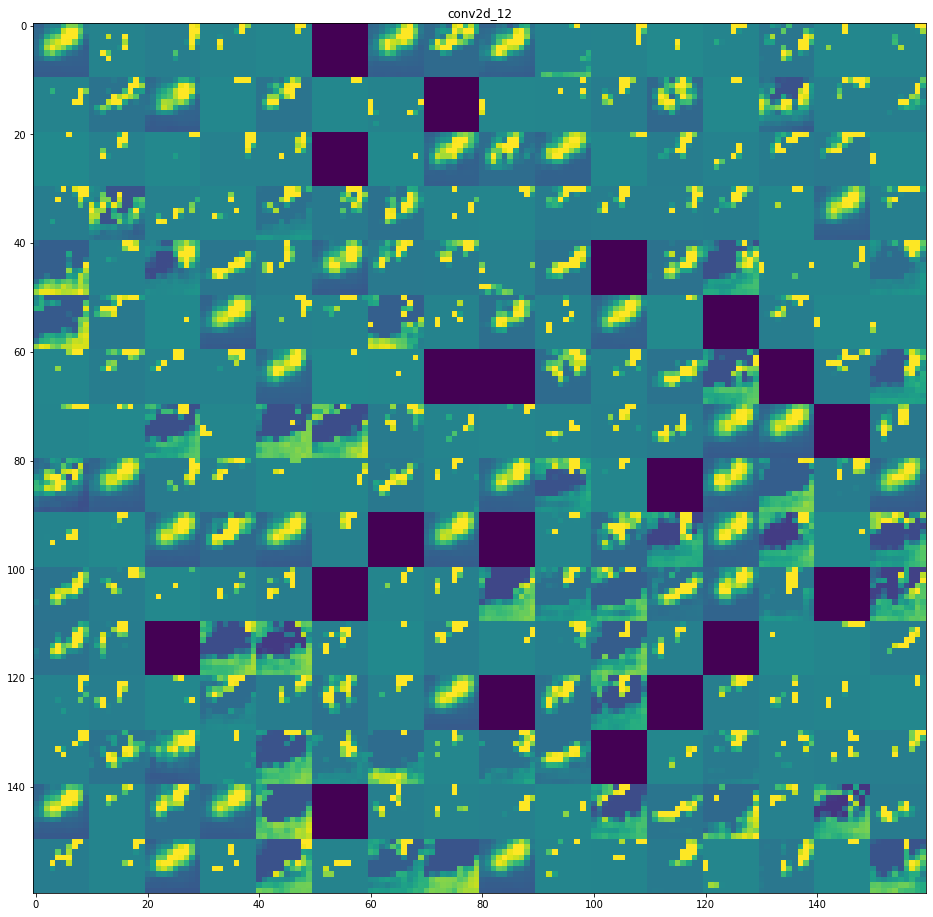

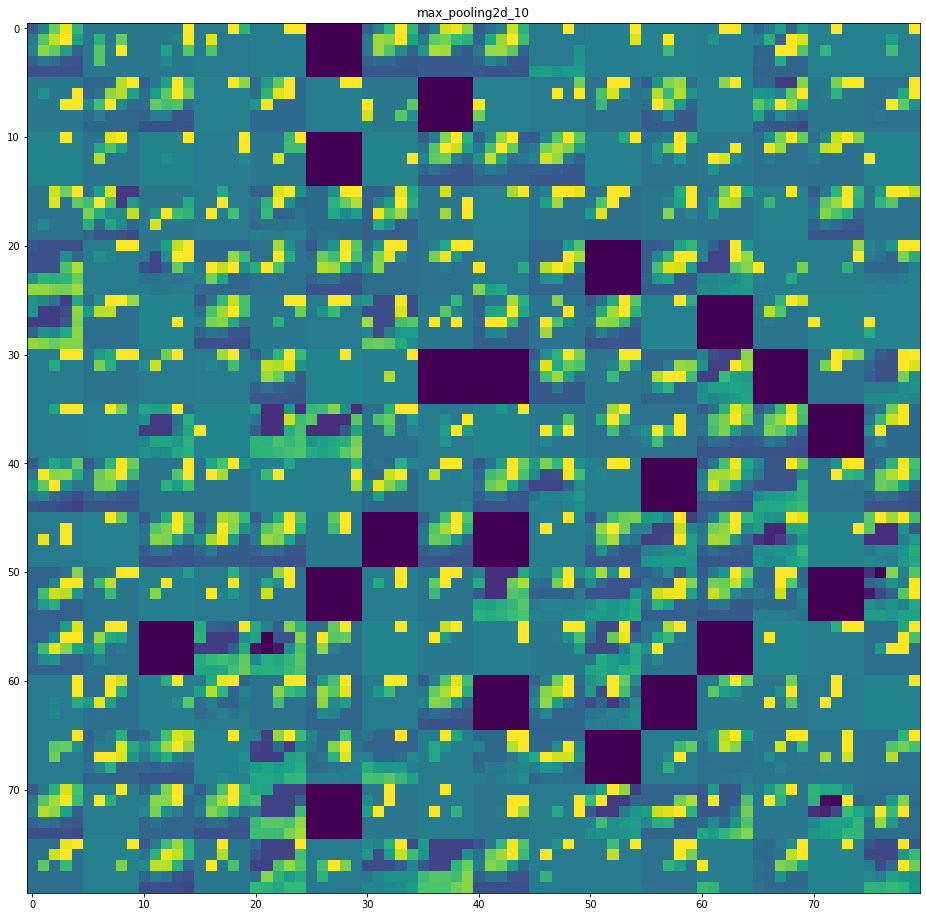

In [0]:
layer_names = []
for layer in network_03.layers[:11]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()